In [1]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

### Load Data

In [2]:
users_df = pd.read_csv('Data/takehome_users.csv', encoding='ISO-8859-1')
engagement_df = pd.read_csv('Data/takehome_user_engagement.csv', encoding='ISO-8859-1')

#inspect first few rows
print(users_df.head())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [3]:
print(engagement_df.head())

            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1


### Data Cleaning

In [4]:
#convert time_stamp to datetime
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

#sort engagement data by user_id and time_stamp for chronological order
engagement_df.sort_values(['user_id', 'time_stamp'], inplace=True)

#check for missing values
print(users_df.isnull().sum())

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64


In [5]:
print(engagement_df.isnull().sum())

time_stamp    0
user_id       0
visited       0
dtype: int64


In [6]:
#fill missing last_session_creation_time with creation_time
users_df['last_session_creation_time'].fillna(users_df['creation_time'], inplace=True)

#create binary column to mark users who never logged in
users_df['never_logged_in'] = users_df['last_session_creation_time'].isnull().astype(int)

C:\Users\aless\AppData\Local\Temp\ipykernel_30088\3018081280.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users_df['last_session_creation_time'].fillna(users_df['creation_time'], inplace=True)
C:\Users\aless\AppData\Local\Temp\ipykernel_30088\3018081280.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['2013-07-31 05:34:02' '2013-11-05 04:04:24' '2014-04-17 23:48:38' ...
 '2013-07-08 17:23:26' '2013-03-28 23:24:21' '2012-06-05 04:46:16

In [7]:
#fill missing invited_by_user_id with 0
users_df['invited_by_user_id'].fillna(0, inplace=True)

#create binary feature for if a user was invited
users_df['was_invited'] = users_df['invited_by_user_id'].apply(lambda x: 0 if x == 0 else 1)

C:\Users\aless\AppData\Local\Temp\ipykernel_30088\2564945778.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users_df['invited_by_user_id'].fillna(0, inplace=True)


### Identify Adopted Users

In [8]:
#extract date part from 'time_stamp' to ignore the time portion
engagement_df['login_date'] = engagement_df['time_stamp'].dt.date

#group by user_id and login_date to count distinct logins
login_days = engagement_df.groupby(['user_id', 'login_date']).size().reset_index(name='login_count')

#sort login_days df by user_id and login_date
login_days.sort_values(['user_id', 'login_date'], inplace=True)

#define function to check if user has 3 logins in 7-day window
def check_adopted_user(df):
    # Loop through each user's login dates and check if there are 3 logins within 7 days
    for i in range(len(df) - 2):  # Ensure at least 3 entries are present
        # Check if the difference between the first and third login is 7 days or less
        if (df['login_date'].iloc[i + 2] - df['login_date'].iloc[i]).days <= 7:
            return True
    return False

#apply function to each user
adopted_users = login_days.groupby('user_id').apply(check_adopted_user).reset_index(name='adopted')

#get list of adopted user_ids
adopted_user_ids = adopted_users[adopted_users['adopted'] == True]['user_id'].unique()

#display adopted user IDs
print(adopted_user_ids)

[    2    10    20 ... 11969 11975 11988]


C:\Users\aless\AppData\Local\Temp\ipykernel_30088\1086259686.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adopted_users = login_days.groupby('user_id').apply(check_adopted_user).reset_index(name='adopted')


### Merge Data

In [9]:
#add new column in users_df
users_df['adopted'] = users_df['object_id'].isin(adopted_user_ids)

#display first few rows
print(users_df.head())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE               1398138810.0   
1      MatthewPoole@gustr.com      ORG_INVITE               1396237504.0   
2  MitchellBottrill@gustr.com      ORG_INVITE               1363734892.0   
3   NicklasSClausen@yahoo.com    GUEST_INVITE               1369210168.0   
4          GraceRaw@yahoo.com    GUEST_INVITE               1358849660.0   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2    

In [10]:
#summary statistics for adoption
print(users_df.groupby('creation_source')['adopted'].mean())
print(users_df.groupby('opted_in_to_mailing_list')['adopted'].mean())

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted, dtype: float64
opted_in_to_mailing_list
0    0.136243
1    0.143287
Name: adopted, dtype: float64


### Predictive Modeling

In [11]:
#select relevant features and target variable
features = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']
X = pd.get_dummies(users_df[features], drop_first=True)  #one-hot encoding for categorical variables
y = users_df['adopted']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

#make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 86.11%
Confusion Matrix:
 [[3100    0]
 [ 500    0]]


### Writeup

I explored the relationship between user adoption and various factors such as creation_source and opted_in_to_mailing_list. Users invited via the "GUEST_INVITE" and "SIGNUP_GOOGLE_AUTH" methods had higher adoption rates (17.06% and 17.26%, respectively). Additionally, users who opted into the mailing list had a slightly higher adoption rate (14.33% vs. 13.62%).

A logistic regression model was built to predict user adoption based on the features creation_source, opted_in_to_mailing_list, and enabled_for_marketing_drip. After splitting the data into training and test sets, the model achieved an accuracy of 86.11%. However, the model’s predictions showed a bias toward predicting non-adopted users, as indicated by the confusion matrix (3100 true negatives and 500 false positives).

The features related to user sign-up methods and email marketing were predictive of user adoption. Users who signed up via invitations or Google authentication were more likely to adopt the product. Marketing engagement (via email opt-ins) also had a small but noticeable impact on adoption.

Further research could focus on other user behaviors, such as time to first login or the number of interactions in the first 30 days, as potential predictors. More advanced models like Random Forest or Gradient Boosting could also be tested to improve predictive performance, particularly for better balancing false positives and negatives.

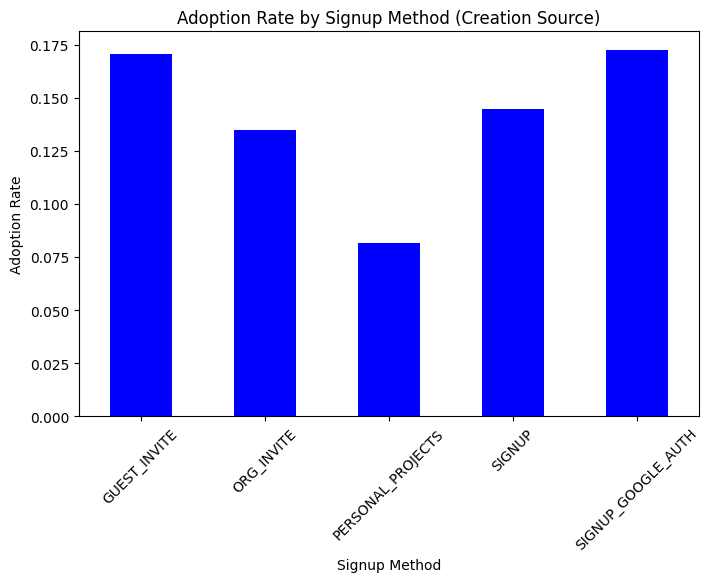

In [14]:
#plot adoption rates by creation source
adoption_by_creation_source = users_df.groupby('creation_source')['adopted'].mean()

plt.figure(figsize=(8, 5))
adoption_by_creation_source.plot(kind='bar', color='blue')
plt.title('Adoption Rate by Signup Method (Creation Source)')
plt.ylabel('Adoption Rate')
plt.xlabel('Signup Method')
plt.xticks(rotation=45)
plt.show()

This bar chart illustrates the adoption rate for users based on how they signed up for the product. Users who signed up through GUEST_INVITE and SIGNUP_GOOGLE_AUTH had the highest adoption rates (around 17.5%). This suggests that users who are invited or use Google authentication are more likely to engage deeply with the product. On the other hand, users signing up through PERSONAL_PROJECTS have the lowest adoption rate, which may indicate that users who are invited to personal projects are less likely to adopt the product over time.

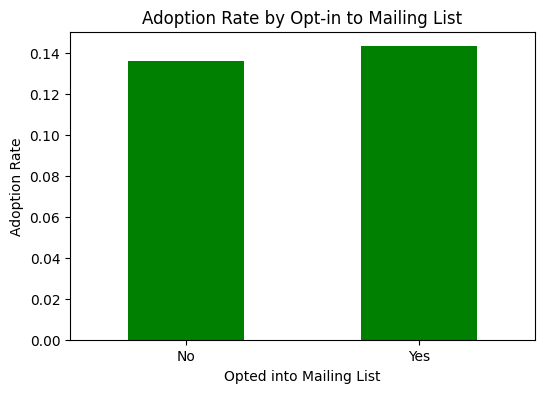

In [15]:
#plot adoption rate based on email opt-in
adoption_by_email_opt_in = users_df.groupby('opted_in_to_mailing_list')['adopted'].mean()

plt.figure(figsize=(6, 4))
adoption_by_email_opt_in.plot(kind='bar', color='green')
plt.title('Adoption Rate by Opt-in to Mailing List')
plt.ylabel('Adoption Rate')
plt.xlabel('Opted into Mailing List')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

This bar chart shows the adoption rate based on whether users opted into the marketing mailing list. Users who opted in had a slightly higher adoption rate (14.38%) compared to those who did not opt in (13.62%). Although the difference is small, it suggests that marketing efforts, such as email engagement, could have a modest impact on user adoption.